<a href="https://colab.research.google.com/github/husnanzzry/FYP_Degree/blob/main/CNN_Model_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib-venn

In [ ]:
!pip install tensorflow

In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from numpy.random import seed
seed(2899)
tf.random.set_seed(99)
from sklearn.model_selection import train_test_split

In [ ]:
import keras

In [ ]:
from keras.models import Sequential

In [ ]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
import keras
from keras.layers import Dense, Activation, Dropout, Reshape, Permute
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Importing dataset

dataset = pd.read_csv("extractsentiment_vader.csv")

In [ ]:
dataset.shape

(11624, 3)

In [ ]:
dataset.head(5)

,text_lemmatized,Score,Sentiment
0,best use maybank app apps run smoothly money m...,1.269231,Positive
1,must malicious apps phone ask change phone upd...,0.282051,Positive
2,service bsn problem news daily light make mybs...,0.205128,Positive
3,maybank apps statement 1 green 99 red,0.000000,Negative
4,something wrong maybank mae apps,-0.538462,Negative


<Axes: xlabel='Sentiment', ylabel='count'>

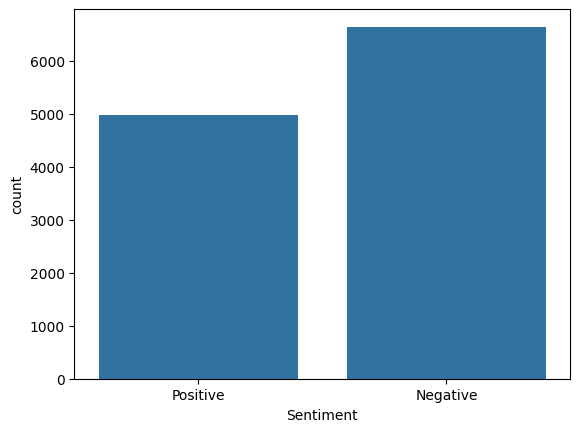

In [ ]:
import seaborn as sns
sns.countplot(x='Sentiment', data=dataset)

<Axes: xlabel='Sentiment', ylabel='count'>

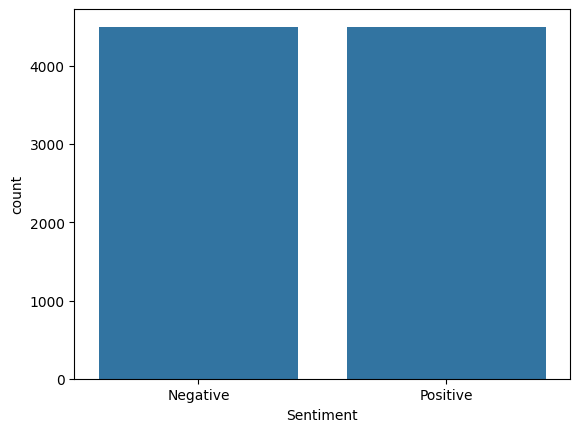

In [ ]:
# Get "Positive" and "Negative" samples
positive_samples = dataset[dataset['Sentiment'] == "Positive"]
negative_samples = dataset[dataset['Sentiment'] == "Negative"]

# Randomly select 4500 samples from each
positive_samples = positive_samples.sample(n=4500, random_state=42)
negative_samples = negative_samples.sample(n=4500, random_state=42)

# Combine the samples
balanced_dataset = pd.concat([positive_samples, negative_samples])

# Shuffle the dataset
dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

sns.countplot(x='Sentiment', data=dataset)

In [ ]:
X = dataset['text_lemmatized']

y = dataset['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))


In [ ]:
X.shape

(9000,)

**SPLIT 70-30**

In [ ]:
# First split to get training+validation (70%) and test sets (30%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split the training+validation set into training (60%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/7, random_state=42, stratify=y_train_val)

# The test_size=1/7 ensures that the validation set is approximately 10% of the original dataset
# and the training set is approximately 60% of the original dataset.


In [ ]:
X_train.shape

(5400,)

In [ ]:
X_val.shape

(900,)

In [ ]:
X_test.shape

(2700,)

PREPARING EMBEDDING LAYER

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

In [ ]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

7391

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(7391, 100)

In [ ]:
X_train.shape

(5400, 100)

In [ ]:
X_val.shape

(900, 100)

In [ ]:
X_test.shape

(2700, 100)

**CNN MODEL 1**

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model1 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model1.add(embedding_layer)
cnn_model1.add(Conv1D(128, 5, activation='relu'))
cnn_model1.add(GlobalMaxPooling1D())
cnn_model1.add(Dense(1, activation='sigmoid'))
cnn_model1.add(Dropout(0.2))
cnn_model1.add(Dense(1, activation='sigmoid'))
cnn_model1.add(Dropout(0.1))
cnn_model1.add(Dense(1, activation='sigmoid'))


In [ ]:
# Model compiling
cnn_model1.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
print(cnn_model1.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          739100    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
 dropout_6 (Dropout)         (None, 1)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 2         
                                                      

In [ ]:
# Model training
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping

cnn_model1_history = cnn_model1.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_val,y_val))

Epoch 1/50
169/169 [==============================] - 7s 32ms/step - loss: 0.7229 - accuracy: 0.4981 - val_loss: 0.7082 - val_accuracy: 0.5000
Epoch 2/50
169/169 [==============================] - 4s 23ms/step - loss: 0.7042 - accuracy: 0.5028 - val_loss: 0.6983 - val_accuracy: 0.5000
Epoch 3/50
169/169 [==============================] - 4s 27ms/step - loss: 0.6978 - accuracy: 0.5006 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 4/50
169/169 [==============================] - 6s 34ms/step - loss: 0.6955 - accuracy: 0.5011 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 5/50
169/169 [==============================] - 4s 24ms/step - loss: 0.6953 - accuracy: 0.4970 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/50
169/169 [==============================] - 4s 24ms/step - loss: 0.6925 - accuracy: 0.5117 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/50
169/169 [==============================] - 6s 37ms/step - loss: 0.6953 - accuracy: 0.4956 - val_loss: 0.6933 - val_accuracy: 0.4956

In [ ]:

# Predictions on the Test Set

score_cnn_model1= cnn_model1.evaluate(X_test, y_test, verbose=1)

85/85 [==============================] - 1s 10ms/step - loss: 0.4125 - accuracy: 0.8600


In [ ]:
print("Test Accuracy: %.2f%%" % (score_cnn_model1[1]*100))
print("Test Loss: %.2f%%" % (score_cnn_model1[0]*100))

Test Accuracy: 86.00%
Test Loss: 41.25%


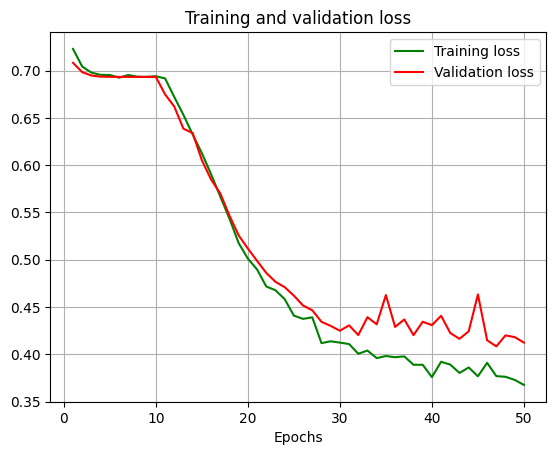

In [ ]:
from matplotlib import pyplot as plt
loss = cnn_model1_history.history['loss']
val_loss = cnn_model1_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

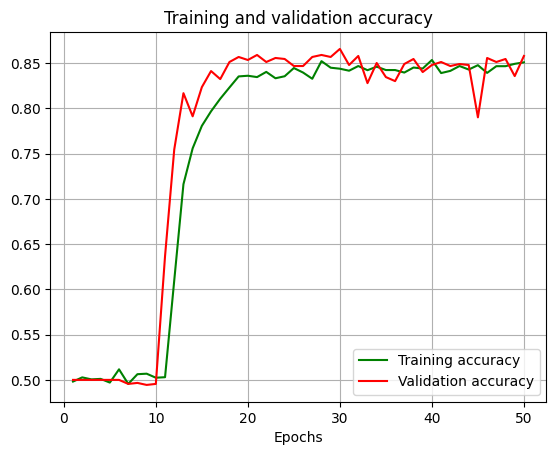

In [ ]:
from matplotlib import pyplot as plt
loss = cnn_model1_history.history['accuracy']
val_loss = cnn_model1_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

85/85 [==============================] - 1s 10ms/step


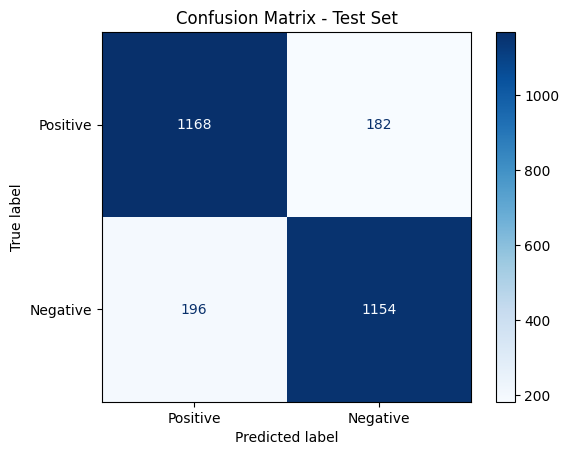

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions for the test sets
y_true = cnn_model1.predict(X_test)

# Convert probabilities to binary labels
y_true = (y_true > 0.5).astype(int)

# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_true)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive', 'Negative'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Print classification report for the test set
print("Classification Report")
print(classification_report(y_test, y_true, target_names=['Negative', 'Positive']))

Classification Report
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.86      1350
    Positive       0.86      0.85      0.86      1350

    accuracy                           0.86      2700
   macro avg       0.86      0.86      0.86      2700
weighted avg       0.86      0.86      0.86      2700



**CNN MODEL 2**

In [ ]:
# First split to get training+validation (70%) and test sets (30%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split the training+validation set into training (60%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/7, random_state=42, stratify=y_train_val)

# The test_size=1/7 ensures that the validation set is approximately 10% of the original dataset
# and the training set is approximately 60% of the original dataset.


PREPARING EMBEDDING LAYER

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

In [ ]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

7391

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model2 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model2.add(embedding_layer)
cnn_model2.add(Conv1D(128, 5, activation='relu'))
cnn_model2.add(GlobalMaxPooling1D())
cnn_model2.add(Dense(1, activation='sigmoid'))
cnn_model2.add(Dropout(0.2))
cnn_model2.add(Dense(1, activation='sigmoid'))
cnn_model2.add(Dropout(0.1))
cnn_model2.add(Dense(1, activation='sigmoid'))


In [ ]:
# Model compiling
cnn_model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
print(cnn_model2.summary())


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          739100    
                                                                 
 conv1d_7 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_7 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
 dropout_11 (Dropout)        (None, 1)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                 2         
                                                      

In [ ]:
# Model training
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping

cnn_model2_history = cnn_model2.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_val,y_val))

Epoch 1/100
169/169 [==============================] - 6s 26ms/step - loss: 0.7046 - accuracy: 0.4981 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 2/100
169/169 [==============================] - 6s 38ms/step - loss: 0.6962 - accuracy: 0.5028 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 3/100
169/169 [==============================] - 4s 24ms/step - loss: 0.6957 - accuracy: 0.5006 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/100
169/169 [==============================] - 5s 28ms/step - loss: 0.6944 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
169/169 [==============================] - 7s 39ms/step - loss: 0.6946 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
169/169 [==============================] - 4s 24ms/step - loss: 0.6930 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4956
Epoch 7/100
169/169 [==============================] - 4s 24ms/step - loss: 0.6934 - accuracy: 0.5148 - val_loss: 0.6826 - val_accuracy:

In [ ]:

# Predictions on the Test Set

score_cnn_model2= cnn_model2.evaluate(X_test, y_test, verbose=1)

85/85 [==============================] - 1s 10ms/step - loss: 0.3953 - accuracy: 0.8607


In [ ]:
print("Test Accuracy: %.2f%%" % (score_cnn_model2[1]*100))
print("Test Loss: %.2f%%" % (score_cnn_model2[0]*100))

Test Accuracy: 86.07%
Test Loss: 39.53%


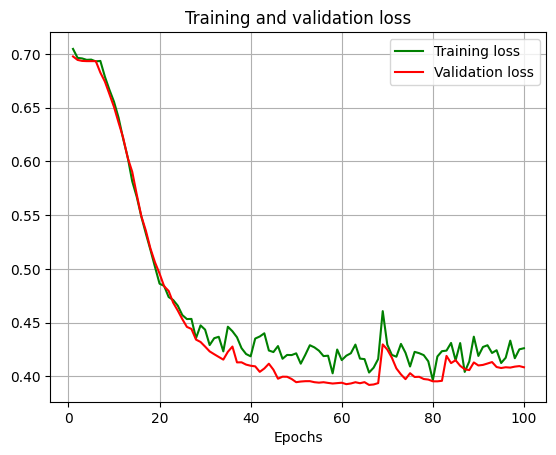

In [ ]:
from matplotlib import pyplot as plt
loss = cnn_model2_history.history['loss']
val_loss = cnn_model2_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

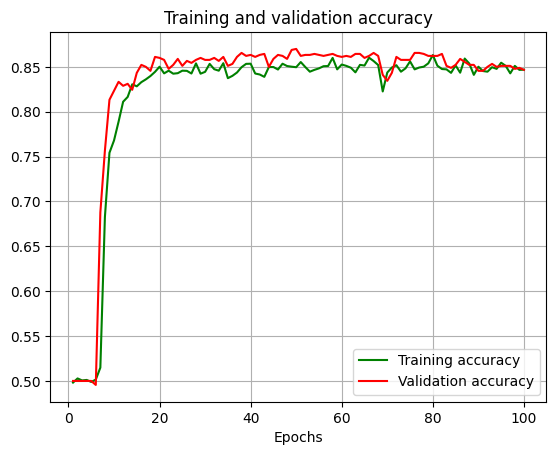

In [ ]:
from matplotlib import pyplot as plt
loss = cnn_model2_history.history['accuracy']
val_loss = cnn_model2_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

85/85 [==============================] - 1s 10ms/step


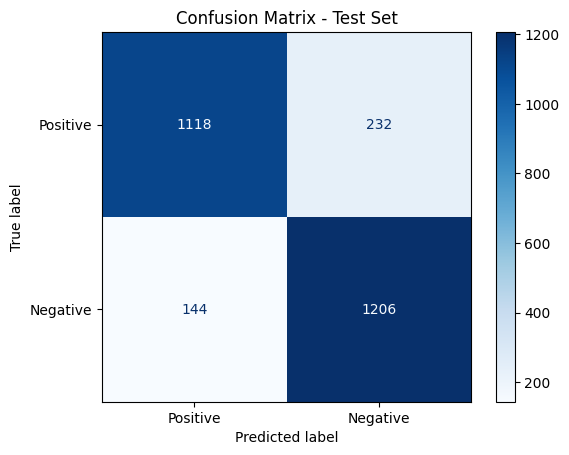

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions for the test sets
y_true = cnn_model2.predict(X_test)

# Convert probabilities to binary labels
y_true = (y_true > 0.5).astype(int)

# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_true)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive', 'Negative'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Print classification report for the test set
print("Classification Report")
print(classification_report(y_test, y_true, target_names=['Negative', 'Positive']))

Classification Report
              precision    recall  f1-score   support

    Negative       0.89      0.83      0.86      1350
    Positive       0.84      0.89      0.87      1350

    accuracy                           0.86      2700
   macro avg       0.86      0.86      0.86      2700
weighted avg       0.86      0.86      0.86      2700



**SPLIT 80-20**

**CNN MODEL 3**

In [ ]:
from sklearn.model_selection import train_test_split

# First split to get training+validation (80%) and test sets (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training+validation set into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

# The test_size=0.125 ensures that the validation set is approximately 10% of the original dataset
# because 0.125 of 80% is 10%.


PREPARING EMBEDDING LAYER

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

In [ ]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

7957

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
X_test.shape

(1800, 100)

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model3 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model3.add(embedding_layer)
cnn_model3.add(Conv1D(128, 5, activation='relu'))
cnn_model3.add(GlobalMaxPooling1D())
cnn_model3.add(Dense(1, activation='sigmoid'))
cnn_model3.add(Dropout(0.2))
cnn_model3.add(Dense(1, activation='sigmoid'))
cnn_model3.add(Dropout(0.1))
cnn_model3.add(Dense(1, activation='sigmoid'))


In [ ]:
# Model compiling
cnn_model3.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
print(cnn_model3.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          795700    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                        

In [ ]:
# Model training
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping

cnn_model3_history = cnn_model3.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_val,y_val))

Epoch 1/50
197/197 [==============================] - 6s 25ms/step - loss: 0.6956 - accuracy: 0.4984 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 2/50
197/197 [==============================] - 6s 29ms/step - loss: 0.6847 - accuracy: 0.4951 - val_loss: 0.6801 - val_accuracy: 0.5000
Epoch 3/50
197/197 [==============================] - 5s 26ms/step - loss: 0.6765 - accuracy: 0.5438 - val_loss: 0.6723 - val_accuracy: 0.7633
Epoch 4/50
197/197 [==============================] - 5s 24ms/step - loss: 0.6659 - accuracy: 0.7633 - val_loss: 0.6612 - val_accuracy: 0.8433
Epoch 5/50
197/197 [==============================] - 7s 34ms/step - loss: 0.6519 - accuracy: 0.7890 - val_loss: 0.6491 - val_accuracy: 0.8267
Epoch 6/50
197/197 [==============================] - 5s 24ms/step - loss: 0.6346 - accuracy: 0.8116 - val_loss: 0.6319 - val_accuracy: 0.8489
Epoch 7/50
197/197 [==============================] - 5s 24ms/step - loss: 0.6187 - accuracy: 0.8102 - val_loss: 0.6147 - val_accuracy: 0.8511

In [ ]:

# Predictions on the Test Set

score_cnn_model3= cnn_model3.evaluate(X_test, y_test, verbose=1)

57/57 [==============================] - 1s 10ms/step - loss: 0.3950 - accuracy: 0.8656


In [ ]:
print("Test Accuracy: %.2f%%" % (score_cnn_model3[1]*100))
print("Test Loss: %.2f%%" % (score_cnn_model3[0]*100))

Test Accuracy: 86.56%
Test Loss: 39.50%


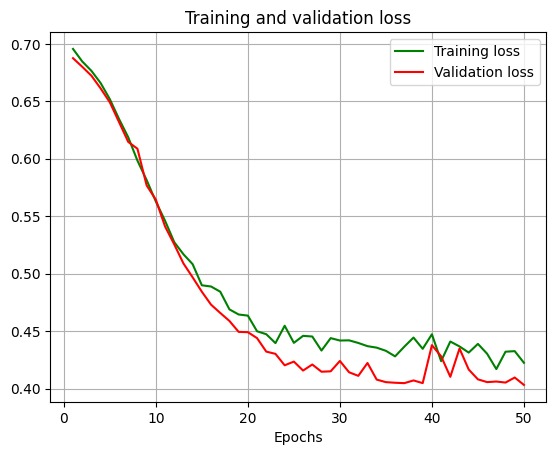

In [ ]:
from matplotlib import pyplot as plt
loss = cnn_model3_history.history['loss']
val_loss = cnn_model3_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

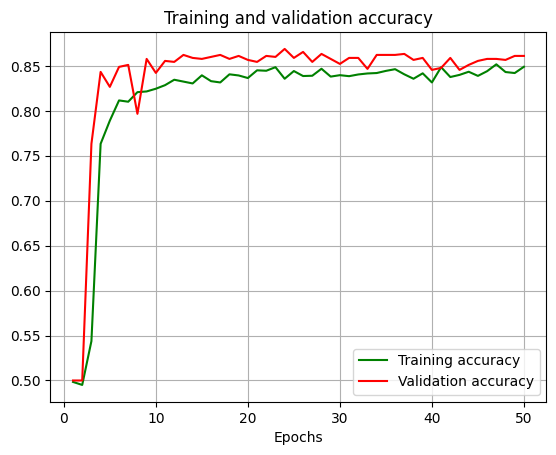

In [ ]:
from matplotlib import pyplot as plt
loss = cnn_model3_history.history['accuracy']
val_loss = cnn_model3_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

57/57 [==============================] - 1s 9ms/step


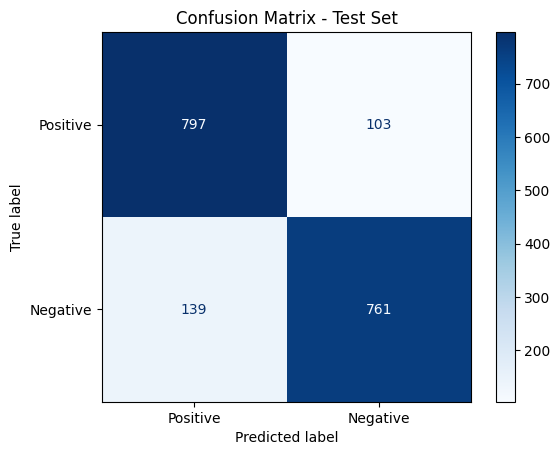

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions for the test sets
y_true = cnn_model3.predict(X_test)

# Convert probabilities to binary labels
y_true = (y_true > 0.5).astype(int)

# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_true)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive', 'Negative'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Print classification report for the test set
print("Classification Report")
print(classification_report(y_test, y_true, target_names=['Negative', 'Positive']))

Classification Report
              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87       900
    Positive       0.88      0.85      0.86       900

    accuracy                           0.87      1800
   macro avg       0.87      0.87      0.87      1800
weighted avg       0.87      0.87      0.87      1800



**CNN MODEL 4**

In [ ]:
from sklearn.model_selection import train_test_split

# First split to get training+validation (80%) and test sets (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training+validation set into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

# The test_size=0.125 ensures that the validation set is approximately 10% of the original dataset
# because 0.125 of 80% is 10%.


PREPARING EMBEDDING LAYER

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

In [ ]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

7957

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model4 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model4.add(embedding_layer)
cnn_model4.add(Conv1D(128, 5, activation='relu'))
cnn_model4.add(GlobalMaxPooling1D())
cnn_model4.add(Dense(1, activation='sigmoid'))
cnn_model4.add(Dropout(0.2))
cnn_model4.add(Dense(1, activation='sigmoid'))
cnn_model4.add(Dropout(0.1))
cnn_model4.add(Dense(1, activation='sigmoid'))


In [ ]:
# Model compiling
cnn_model4.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
print(cnn_model4.summary())


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          795700    
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_10 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
 dropout_17 (Dropout)        (None, 1)                 0         
                                                                 
 dense_28 (Dense)            (None, 1)                 2         
                                                     

In [ ]:
# Model training
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping

cnn_model4_history = cnn_model4.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_val,y_val))

Epoch 1/100
197/197 [==============================] - 8s 35ms/step - loss: 0.6835 - accuracy: 0.5024 - val_loss: 0.6630 - val_accuracy: 0.5000
Epoch 2/100
197/197 [==============================] - 6s 31ms/step - loss: 0.6559 - accuracy: 0.6508 - val_loss: 0.6436 - val_accuracy: 0.7256
Epoch 3/100
197/197 [==============================] - 5s 26ms/step - loss: 0.6364 - accuracy: 0.7513 - val_loss: 0.6339 - val_accuracy: 0.7333
Epoch 4/100
197/197 [==============================] - 7s 36ms/step - loss: 0.6148 - accuracy: 0.7813 - val_loss: 0.6022 - val_accuracy: 0.8267
Epoch 5/100
197/197 [==============================] - 5s 27ms/step - loss: 0.5949 - accuracy: 0.7992 - val_loss: 0.5824 - val_accuracy: 0.8400
Epoch 6/100
197/197 [==============================] - 6s 31ms/step - loss: 0.5692 - accuracy: 0.8176 - val_loss: 0.5647 - val_accuracy: 0.8344
Epoch 7/100
197/197 [==============================] - 7s 37ms/step - loss: 0.5532 - accuracy: 0.8198 - val_loss: 0.5381 - val_accuracy:

In [ ]:

# Predictions on the Test Set

score_cnn_model4= cnn_model4.evaluate(X_test, y_test, verbose=1)

57/57 [==============================] - 1s 10ms/step - loss: 0.3926 - accuracy: 0.8639


In [ ]:
print("Test Accuracy: %.2f%%" % (score_cnn_model4[1]*100))
print("Test Loss: %.2f%%" % (score_cnn_model4[0]*100))

Test Accuracy: 86.39%
Test Loss: 39.26%


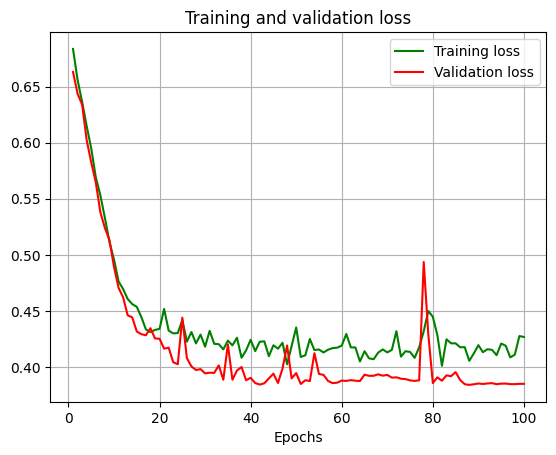

In [ ]:
from matplotlib import pyplot as plt
loss = cnn_model4_history.history['loss']
val_loss = cnn_model4_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

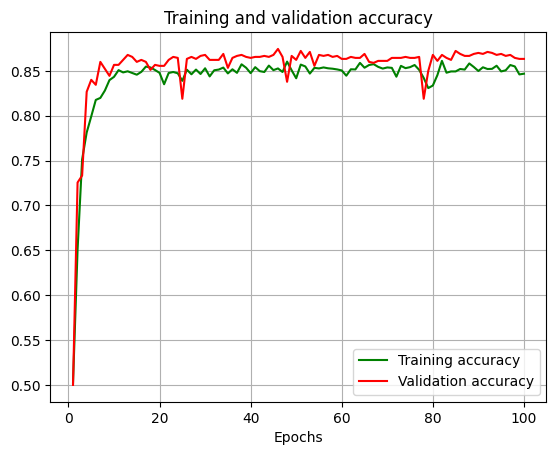

In [ ]:
from matplotlib import pyplot as plt
loss = cnn_model4_history.history['accuracy']
val_loss = cnn_model4_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

57/57 [==============================] - 1s 16ms/step


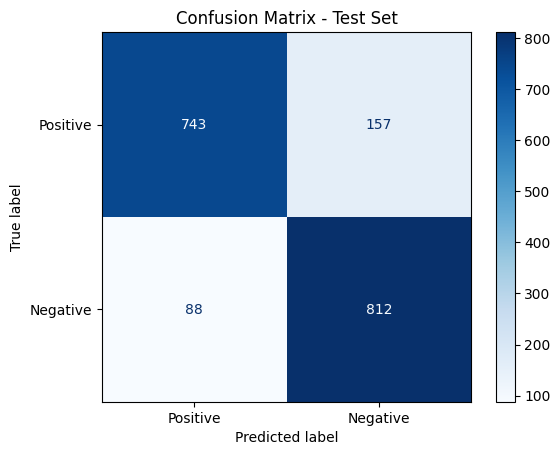

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions for the test sets
y_true = cnn_model4.predict(X_test)

# Convert probabilities to binary labels
y_true = (y_true > 0.5).astype(int)

# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_true)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive', 'Negative'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Print classification report for the test set
print("Classification Report")
print(classification_report(y_test, y_true, target_names=['Negative', 'Positive']))

Classification Report
              precision    recall  f1-score   support

    Negative       0.89      0.83      0.86       900
    Positive       0.84      0.90      0.87       900

    accuracy                           0.86      1800
   macro avg       0.87      0.86      0.86      1800
weighted avg       0.87      0.86      0.86      1800

